## FedeNET

----

#### Goal:
Develop a custom CNN for **binary classification (flip vs notflip)** that is efficient, task-focused, and original, integrating **frequency sensitivity** directly at the input level instead of relying solely on deeper convolutional layers to capture it.

The design is inspired by the **brightness and blur analysis** (via Laplacian Variance Map) performed on the dataset, where *flip* images consistently showed higher blur and lower sharpness compared to *notflip* images.

FedeNET explicitly incorporates this insight by introducing fixed, precomputed frequency maps that help the model distinguish between motion-blurred and static frames more effectively.   


----


#### Imports and Environment

In [3]:
import os, random
from pathlib import Path
import numpy as np
import torch
import torchvision.transforms as tvT


In [4]:
import fedenet
from fedenet import __version__ as FEDE_VERSION
from fedenet.transforms import NormalizeRGBOnly, ResizePad, AppendFrequencyMaps
from fedenet.models import FedeNetTiny


In [5]:
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


torch: 2.5.1+cu121
built with CUDA: 12.1
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [6]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Access the datasets
DATA_ROOT = Path("data") / "images"
splits = ["training", "testing"]
classes = ["flip", "notflip"]

for split in splits:
    for cls in classes:
        p = DATA_ROOT / split / cls
        assert p.is_dir(), f"Missing folder: {p}"
print("Folder structure looks OK.")

Folder structure looks OK.


----

### Step 1 - Precomputed Frequency Maps

This transform:
  - converts image to grayscale
  - computes fixed, zero-parameter frequency maps:
    - 1 Sobel gradient magnitude (edges)
    - 2 Laplacian magnitude (second-order structure / blur sensitivity)
    - 3 Local variance (texture / blur sensitivity, window=7)
    - 4- High-pass (unsharp) magnitude (fine detail energy)
  - robust-normalizes each map to [0,1]
  - concatenates maps to RGB => (3 + K, H, W)


In [7]:
import matplotlib.pyplot as plt

In [33]:
def visualize_fede_grid4x4(
    x,
    freq_names=("Sobel", "Laplacian", "LocalVar", "HighPass"),
    figsize=(20, 16),
    bins=50
):
    """
    x: tensor of shape (3 + K, H, W) from AppendFrequencyMaps.
    Produces a 4×4 grid:
      Row1: Composite / R / G / B images
      Row2: Corresponding histograms (Composite average, R, G, B)
      Row3: Frequency maps images: Sobel / Laplacian / LocalVar / HighPass
      Row4: Corresponding histograms of the frequency maps
    """
    assert x.ndim == 3 and x.shape[0] >= 7, f"Expected at least 7 channels, got {x.shape[0]}"
    # Extract RGB and frequency
    rgb = x[:3].permute(1,2,0).cpu().numpy()           # (H, W, 3)
    freq = x[3:3+len(freq_names)].detach().cpu().numpy() # (K, H, W)
    H, W = rgb.shape[:2]
    K = freq.shape[0]
    assert K == 4, f"Expected 4 frequency maps, got {K}"
    
    # Prepare figure with 4 rows and 4 columns
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    max_y_axis_value = 30000
    
    # --- Row 1: images RGB composite + R/G/B ---
    axes[0,0].imshow(rgb)
    axes[0,0].set_title("Composite")
    axes[0,0].axis('off')
    for i, ch in enumerate([0,1,2], start=1):
        axes[0,i].imshow(rgb[:,:,ch], cmap='gray')
        axes[0,i].set_title(["R","G","B"][ch])
        axes[0,i].axis('off')
    
    # --- Row 2: histograms for Composite, R/G/B ---
    # Composite histogram: average across RGB channels
    composite_vals = rgb.reshape(-1,3).mean(axis=1)
    axes[1,0].hist(composite_vals, bins=bins, color='gray', alpha=0.7)
    axes[1,0].set_title("Composite hist")
    axes[1,0].set_xlabel("Value")
    # R/G/B hist
    for i, ch in enumerate([0,1,2], start=1):
        vals = rgb[:,:,ch].reshape(-1)
        axes[1,i].hist(vals, bins=bins, color=['r','g','b'][ch], alpha=0.7)
        axes[1,i].set_ylim(top=max_y_axis_value)
        axes[1,i].set_title(f"{['R','G','B'][ch]} hist")
        axes[1,i].set_xlabel("Value")
    
    # --- Row 3: freq map images ---
    for j, name in enumerate(freq_names):
        axes[2, j].imshow(freq[j,:,:], cmap='gray', vmin=0.0, vmax=1.0)
        axes[2, j].set_title(name)
        axes[2, j].axis('off')
    
    # --- Row 4: histograms of freq maps ---
    for j, name in enumerate(freq_names):
        vals = freq[j,:,:].reshape(-1)
        axes[3, j].hist(vals, bins=bins, color='black', alpha=0.7)
        axes[3, j].set_ylim(top=max_y_axis_value)
        axes[3, j].set_title(f"{name} hist")
        axes[3, j].set_xlabel("Value")
    
    plt.tight_layout()
    plt.show()



In [31]:
from torchvision.io import read_image
from PIL import Image

In [28]:
flip_img_path    = list((DATA_ROOT/"testing"/"flip").rglob("*.*"))[random.randint(0,10)]
notflip_img_path = list((DATA_ROOT/"testing"/"notflip").rglob("*.*"))[random.randint(0,10)]

In [11]:
print("Flip sample:",    flip_img_path)
print("NotFlip sample:", notflip_img_path)

Flip sample: data\images\testing\flip\0002_000000017.jpg
NotFlip sample: data\images\testing\notflip\0001_000000004.jpg


In [12]:
flip_img    = Image.open(flip_img_path).convert("RGB")
notflip_img = Image.open(notflip_img_path).convert("RGB")

In [13]:
TARGET_H, TARGET_W = 540, 960
FREQ_CHANNELS = ("sobel", "laplacian", "localvar", "highpass")

In [15]:
# Build minimal pipeline for visualization
vis_tfms = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.ToTensor(),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    # For visualization: keep frequency maps in [0,1] scale for direct interpretability
    # Note: In training mode we will apply NormalizeRGBOnly to the first 3 channels; we leave the freq‐channels as is.
])

In [16]:
flip_x    = vis_tfms(flip_img)
notflip_x = vis_tfms(notflip_img)

Flip:


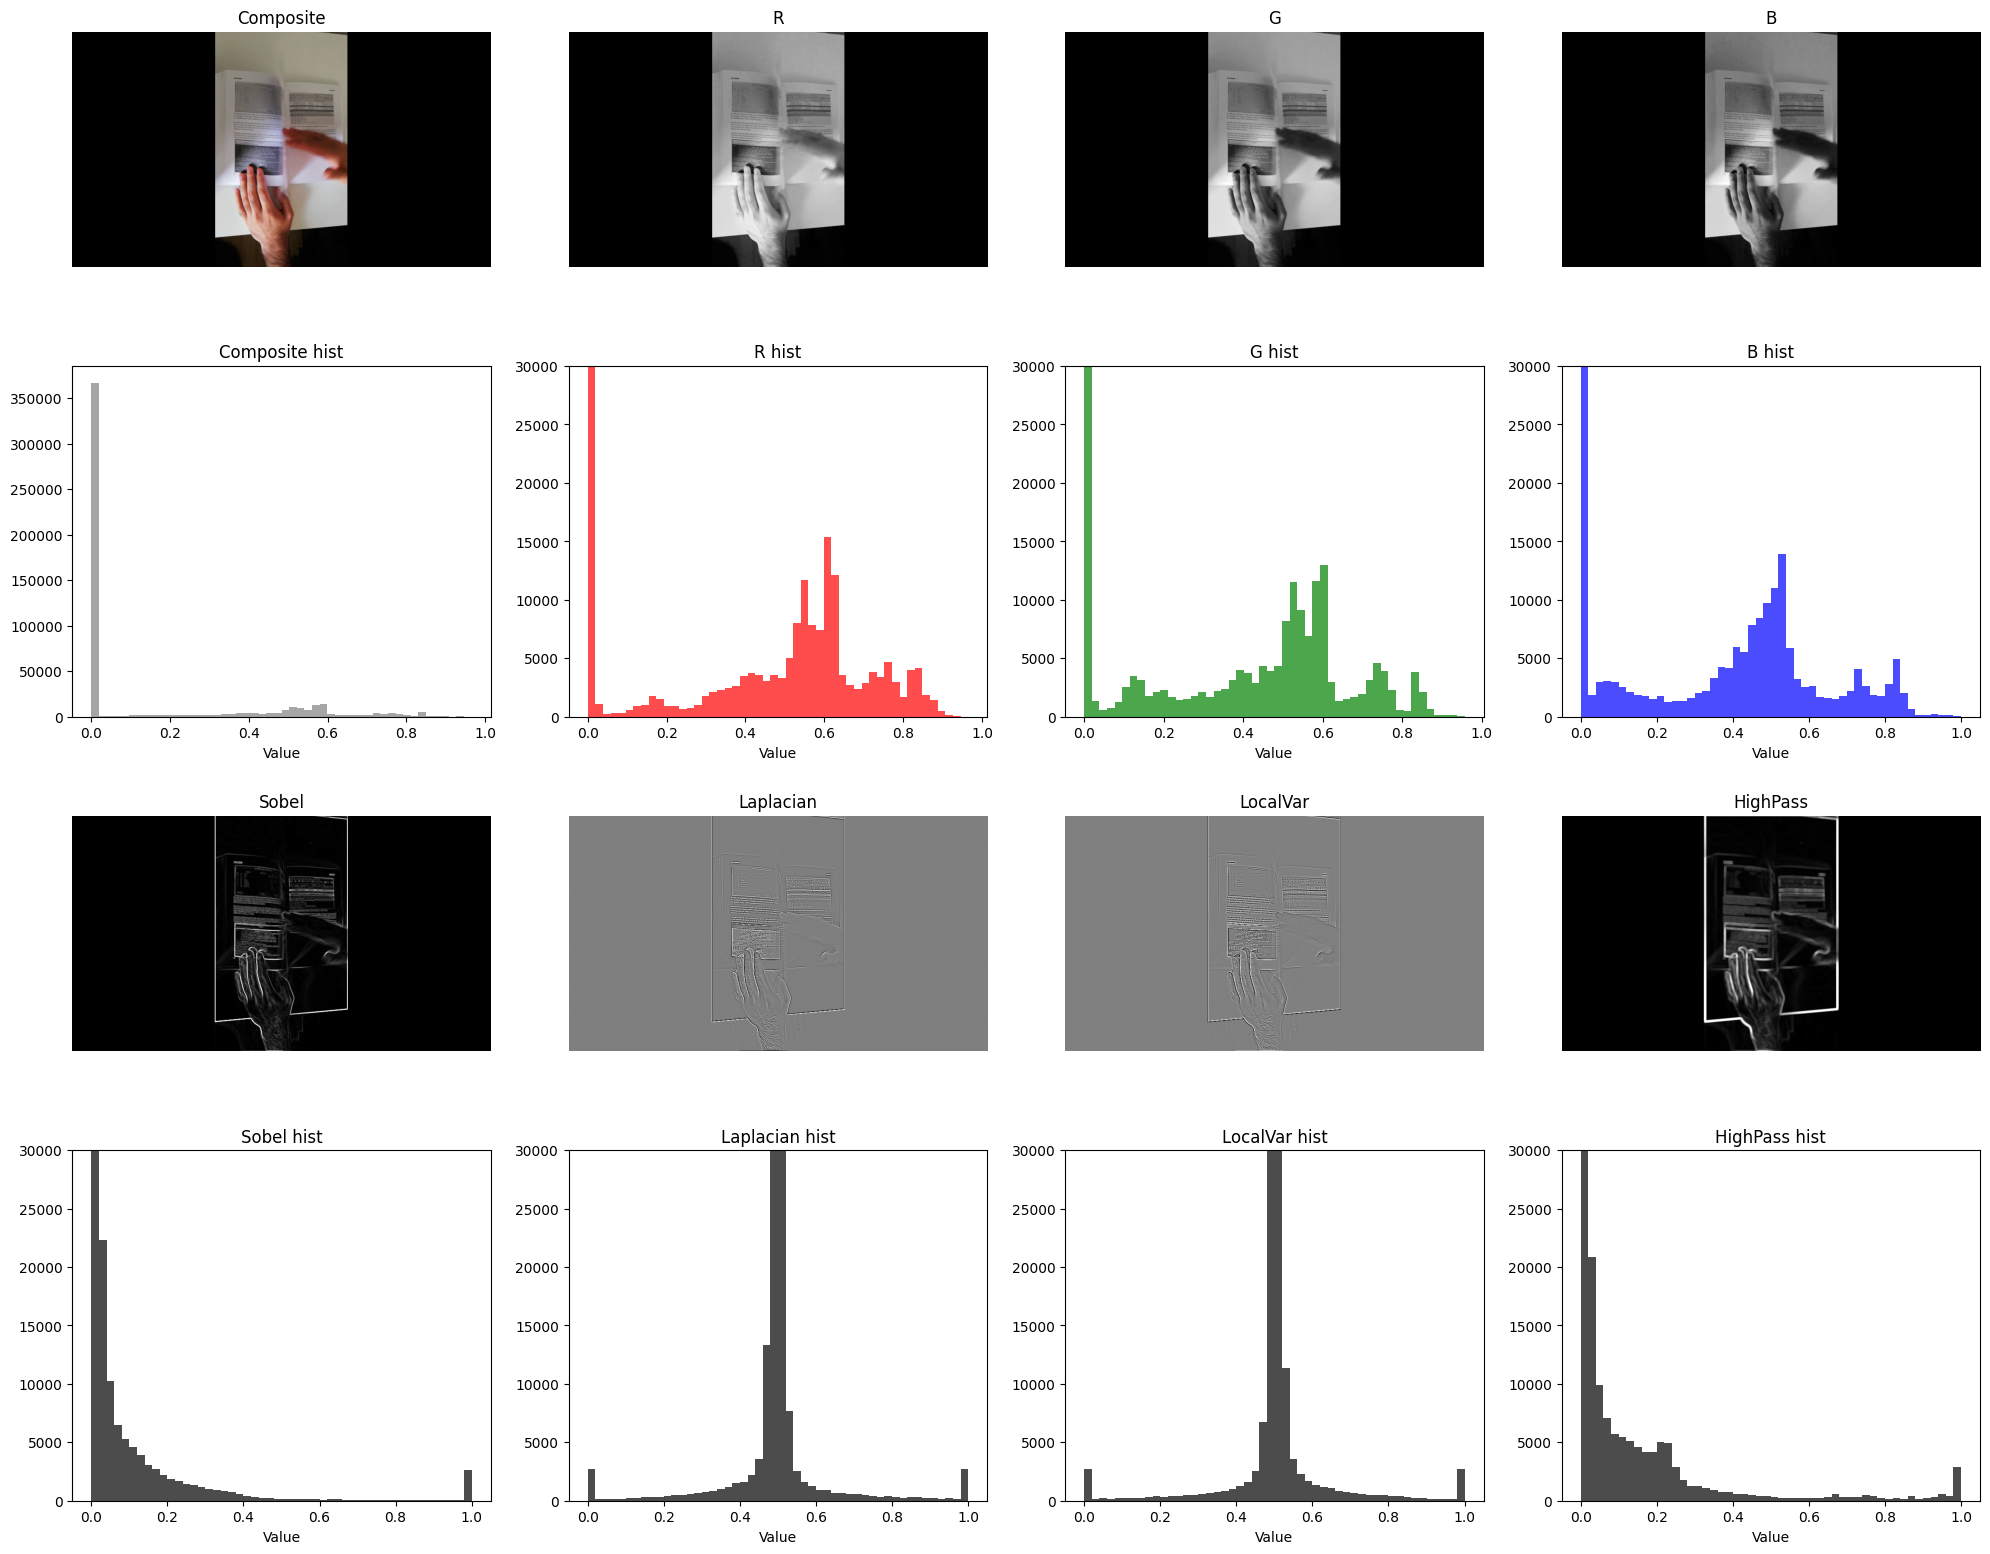

NotFlip:


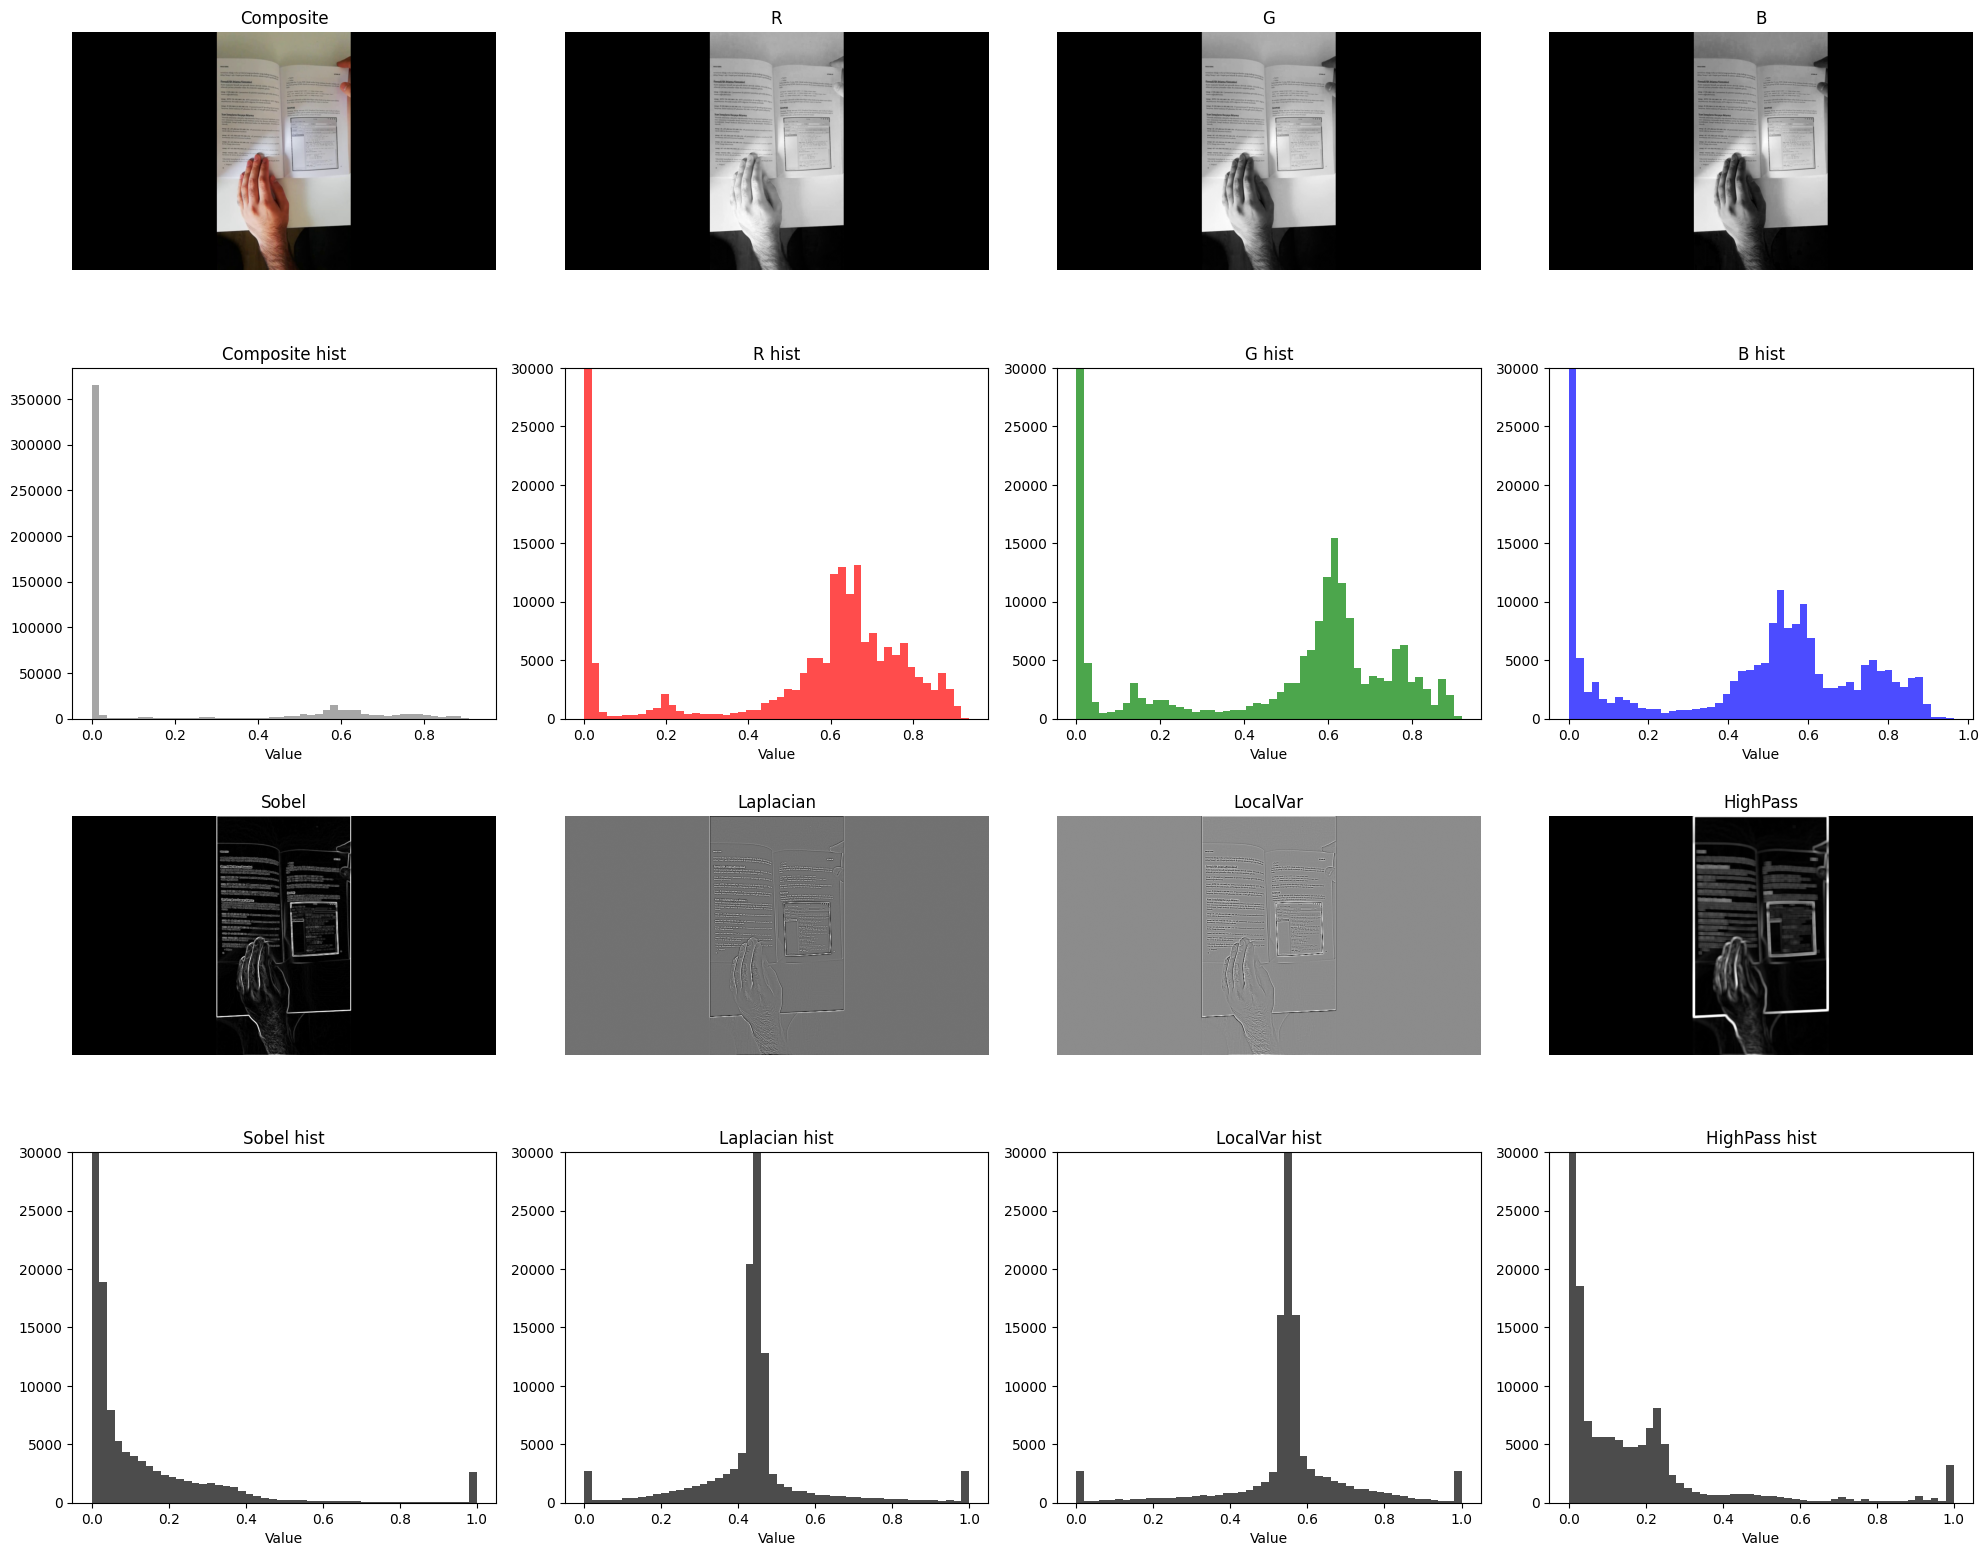

In [34]:
print("Flip:")
visualize_fede_grid4x4(flip_x)
print("NotFlip:")
visualize_fede_grid4x4(notflip_x)

Above we see two representative frames (flip / not-flip) with their corresponding histograms for the RGB channels and the four appended frequency maps (Sobel, Laplacian, LocalVar, HighPass).  

A few key observations:

- The **Sobel** and **HighPass** histograms show long tails towards high values: both filters emphasise rapid intensity changes (edges or fine detail), so many pixels map to low values (smooth regions) and a subset map to high values (sharp transitions).  
- The **Laplacian** and **LocalVar** histograms exhibit a strong peak in the central range with thin tails: the Laplacian (a second-order derivative) responds mainly to changes in the gradient, so most pixels (in flat or gradual regions) yield near-zero responses. Similarly, the LocalVar map (local variance) shows low values in smooth zones, with only textured or noisy patches producing higher responses.  
- Because each map is normalised (min-max or robust quantile → [0, 1]), the dominant “zero/low‐change” regions cluster near the low end, and only the strongest responses are scaled toward 1. This explains why the **Laplacian/LocalVar** histograms appear “centered” rather than dominated by high values.  

In short:  
  - **Sobel**, **HighPass** → first‐order and high‐frequency detail filters → more strong‐response pixels → heavier right‐tail in histogram.  
  - **Laplacian**, **LocalVar** → second‐order or local‐variance filters → many small/zero responses, fewer high responses → strong central peak.

This understanding aligns with the visual results and supports the choice of these maps as complementary features: Sobel/HighPass highlight abrupt structure; Laplacian/LocalVar characterise changes in structure and texture.



### Why adding the 4 frequency-channels improves flip vs not-flip classification  

Appending Sobel, Laplacian, LocalVar and HighPass channels to the original RGB input gives the CNN deeper structural cues beyond mere appearance. For example, Sobel and HighPass highlight first-order edges and fine detail (which are more likely in “not-flip” sharp frames), while Laplacian and LocalVar focus on gradient curvature and local texture uniformity (often lower in “flip” frames with motion/blur). As a result, the model can latch onto differences in edge clarity, label‐text sharpness and blur dynamics that are difficult to capture from RGB alone.  

In practice this results in a seven-channel input where the extra four channels act like engineered “feature maps” emphasising blur/texture/edge patterns. These give the network complementary, orthogonal information which helps reduce confusion caused by variations in lighting or colour. Therefore, the added frequency‐based channels can significantly boost the CNN’s ability to discriminate between flip and not-flip classes by exposing structural and textural degradations rather than relying solely on appearance.  


----

### Step 2 - Dataset and Dataloader setup

In [35]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [36]:
# Base paths
TRAIN_DIR = DATA_ROOT / "training"
TEST_DIR  = DATA_ROOT / "testing"

In [38]:
# Train transform
train_tfms = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.RandomRotation(degrees=5, fill=0),
    tvT.ColorJitter(brightness=0.1, contrast=0.1),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])

# Validation transform
val_tfms   = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])

In [39]:
train_ds = ImageFolder(root=TRAIN_DIR, transform=train_tfms)
val_ds   = ImageFolder(root=TEST_DIR,  transform=val_tfms)

### 1.1 Implementing a Standalone Library and Verifying Its Classes

We will develop a dedicated **Python library** for FedeNET in parallel with this notebook.  
The goal is to organize the full implementation (model, transforms, and utilities) inside a standalone module (`FedeNet.py`) so it can be easily **imported and reused** across different notebooks or projects.  

This approach ensures cleaner experimentation here while keeping the production-ready version portable via:

In [5]:
import FedeNet  # your custom lightweight CNN
from FedeNet import AppendFrequencyMaps, ResizePad, FedeNetTiny

In [6]:
# Target size that respects the 16:9 frames but is lighter than 1080x1920
# Downscaling x2
TARGET_H, TARGET_W = FedeNet.TARGET_H, FedeNet.TARGET_W  # 540, 960
# From ImageNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

In [7]:
# Example integration
# Choose the maps to include:
FREQ_CHANNELS = ("sobel", "laplacian", "localvar", "highpass")

# IMPORTANT: If normalize with ImageNet stats, only apply them to the first 3 channels.
# For the extra frequency channels, either:
#   (A) skip normalization, since they’re already in [0,1], or
#   (B) normalize with mean=0.5, std=0.5 (simple affine to [-1,1]).
# Below, we show (A) for clarity; swap for (B) if desired.

train_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.RandomRotation(degrees=5, fill=0),
    tvT.ColorJitter(brightness=0.1, contrast=0.1),
    # Append frequency maps (now tensor):
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    # Split: normalize RGB only
    #   -> implement a small lambda to normalize first 3 channels
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]  # leave frequency channels as-is (0..1)
    ], dim=0)),
])

In [8]:
val_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])


In [9]:
import matplotlib.pyplot as plt

In [10]:
def _denorm_rgb(rgb3, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """rgb3: (3,H,W) tensor, denorm to [0,1] for display."""
    m = torch.tensor(mean, dtype=rgb3.dtype, device=rgb3.device).view(3,1,1)
    s = torch.tensor(std,  dtype=rgb3.dtype, device=rgb3.device).view(3,1,1)
    x = rgb3 * s + m
    return x.clamp(0, 1)

def visualize_fede_two_rows(x, freq_names=("Sobel","Laplacian","LocalVar","HighPass"),
                            figsize=(16, 8)):
    """
    x: tensor (3+K, H, W) produced *after* AppendFrequencyMaps and (optionally) RGB normalization.
    Shows:
        Row 1: Composite RGB, R, G, B (channel planes)
        Row 2: 4 frequency maps in order they appear after RGB (x[3:], first 4)
    """
    assert x.ndim == 3 and x.shape[0] >= 7, "Expected (>=7, H, W) with 3 RGB + 4 freq maps."

    # RGB composite (denormalize first 3 only)
    rgb = _denorm_rgb(x[:3].clone())
    R, G, B = rgb[0:1], rgb[1:2], rgb[2:3]  # for grayscale display of planes

    # Frequency maps (already 0..1 from our transform)
    fmaps = x[3:7].detach()  # take the first 4 freq channels in the given order

    titles_row1 = ["Composite", "R", "G", "B"]
    titles_row2 = list(freq_names)[:4]

    fig, axes = plt.subplots(2, 4, figsize=figsize)

    # Row 1
    axes[0,0].imshow(rgb.permute(1,2,0).cpu().numpy())
    axes[0,0].set_title(titles_row1[0]); axes[0,0].axis('off')

    for i, ch in enumerate([R, G, B], start=1):
        axes[0,i].imshow(ch.squeeze(0).cpu().numpy(), cmap='gray')
        axes[0,i].set_title(titles_row1[i]); axes[0,i].axis('off')

    # Row 2
    for j in range(4):
        axes[1,j].imshow(fmaps[j].cpu().numpy(), cmap='gray')
        axes[1,j].set_title(titles_row2[j]); axes[1,j].axis('off')

    plt.tight_layout()
    plt.show()


### 1.2 Visualization Test

In [11]:
import pandas as pd
from torchvision.io import read_image
from PIL import ImageOps

In [12]:
# open the csv with the image dataset metadata
extraction_table_file = "all_images.csv"
df = pd.read_csv(DATA_ROOT / extraction_table_file)
df.head()

,Unnamed: 0,path,split,label,w,h,mode,ratio
0,0,data\images\training\flip\0001_000000010.jpg,training,flip,1080,1920,RGB,0.5625
1,1,data\images\training\flip\0001_000000011.jpg,training,flip,1080,1920,RGB,0.5625
2,2,data\images\training\flip\0001_000000012.jpg,training,flip,1080,1920,RGB,0.5625
3,3,data\images\training\flip\0001_000000013.jpg,training,flip,1080,1920,RGB,0.5625
4,4,data\images\training\flip\0001_000000014.jpg,training,flip,1080,1920,RGB,0.5625


In [13]:
flip_rows = df[df['label'] == 'flip']
notflip_rows = df[df['label'] == 'notflip']

# flip image (moving)
flip_image_path = flip_rows.sample(n=1, random_state=SEED)
flip_image_path = flip_image_path['path'].iloc[0]
flip_tensor = read_image(flip_image_path)

# notflip image (static)
notflip_image_path = notflip_rows.sample(n=1, random_state=SEED)
notflip_image_path = notflip_image_path['path'].iloc[0]
notflip_tensor = read_image(notflip_image_path)

In [14]:
flip_image_path, notflip_image_path

('data\\images\\training\\flip\\0061_000000021.jpg',
 'data\\images\\testing\\notflip\\0004_000000029.jpg')

In [15]:
# Choose which pipeline to show
FEDE_TFM = val_tfms_fede   # or train_tfms_fede to see jitter/rotation too

In [16]:
# Build a minimal pipeline that matches your val_tfms_fede (no DA here)
val_tfms_fede_vis = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=("sobel","laplacian","localvar","highpass")),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])

Flip: data\images\training\flip\0061_000000021.jpg


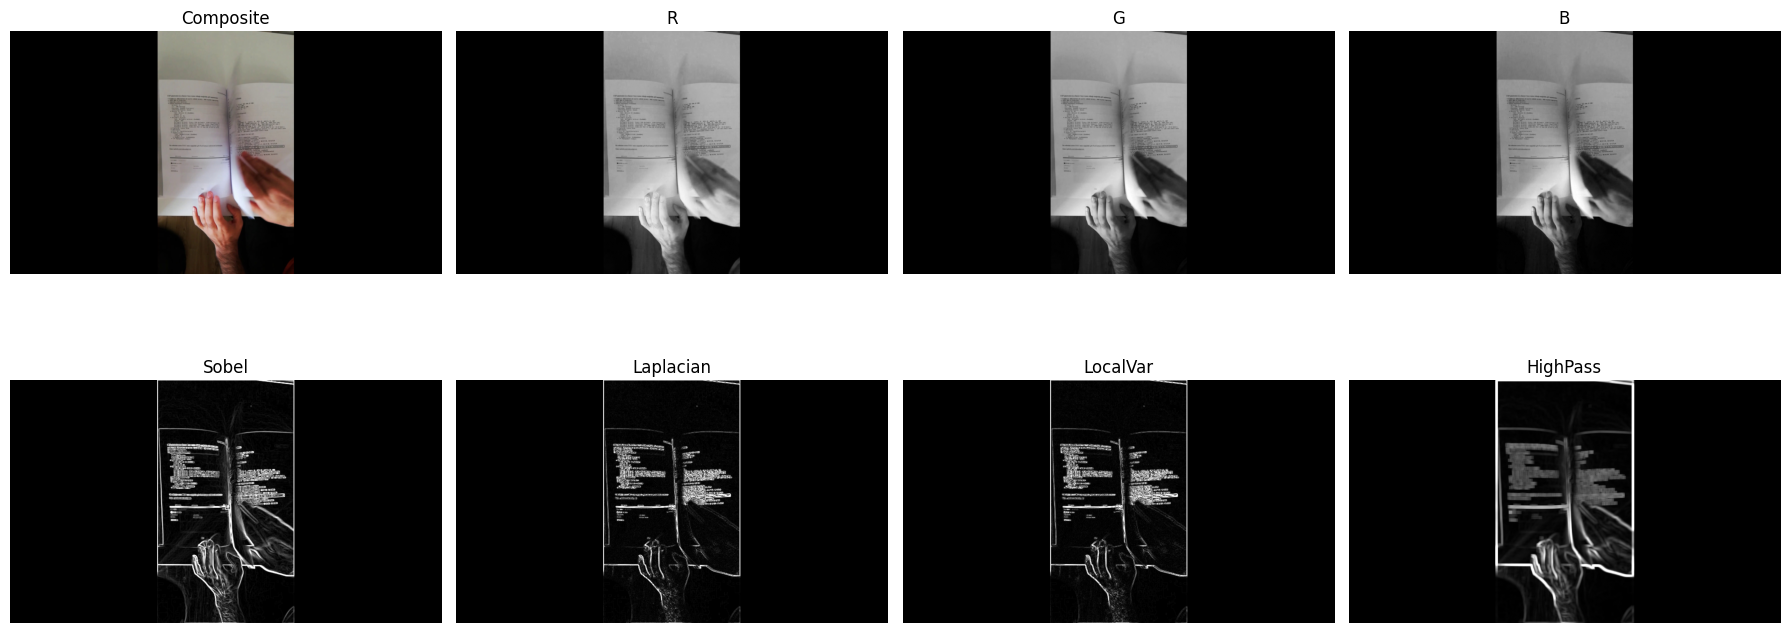

Notflip: data\images\testing\notflip\0004_000000029.jpg


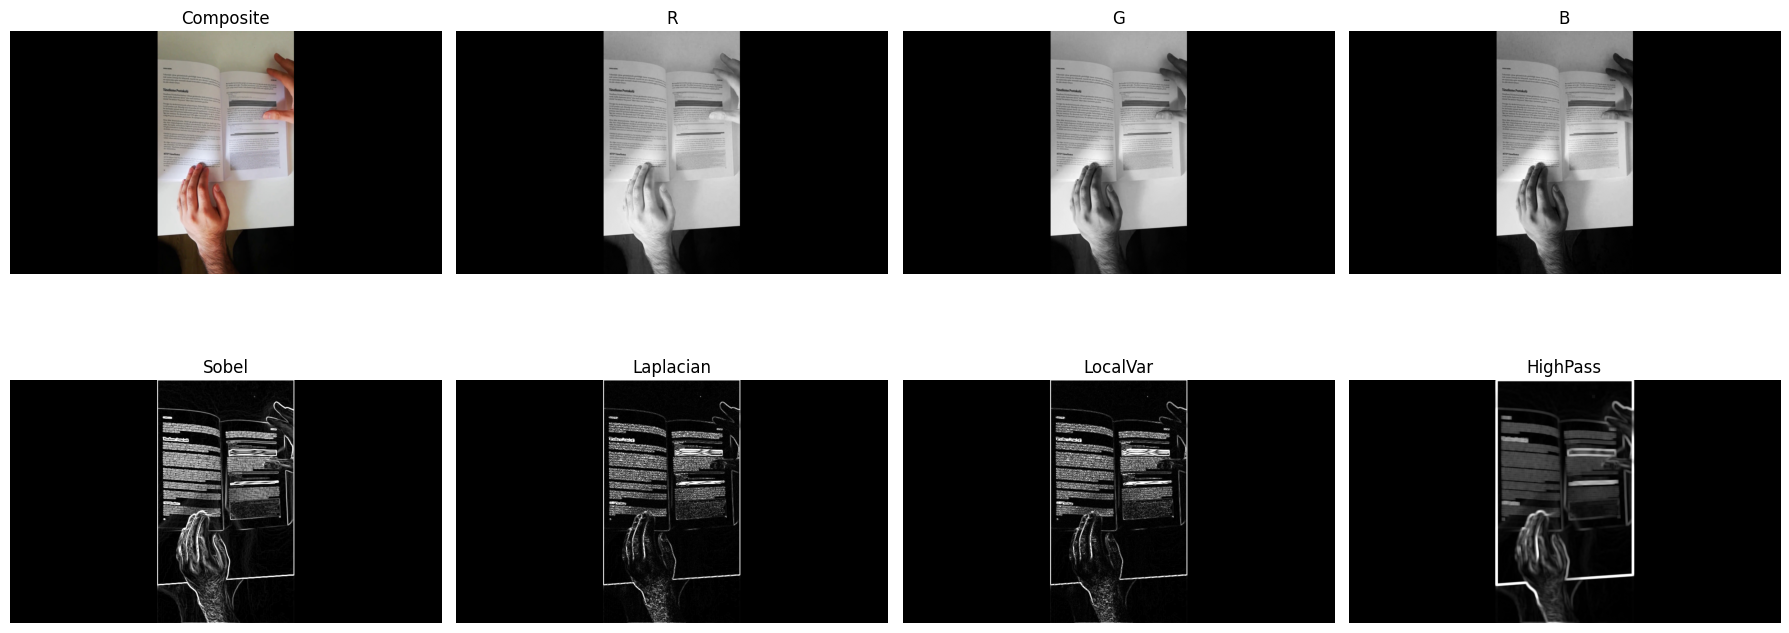

In [17]:
# Load paths from the df
flip_img = Image.open(flip_image_path).convert("RGB")
notflip_img = Image.open(notflip_image_path).convert("RGB")

flip_x = val_tfms_fede_vis(flip_img)      # (7, H, W)
notflip_x = val_tfms_fede_vis(notflip_img)

print("Flip:", flip_image_path)
visualize_fede_two_rows(flip_x, figsize=(18, 8))

print("Notflip:", notflip_image_path)
visualize_fede_two_rows(notflip_x, figsize=(18, 8))

In [18]:
flip_x.shape

torch.Size([7, 540, 960])

### Frequency-Channel Visualization: Key Findings

**Setup:** RGB frames + four fixed maps (Sobel, Laplacian, LocalVar, HighPass), after `ResizePad` (centered, aspect-preserving).

**Observations**
- **RGB (Composite, R/G/B):** Clean, centered inputs.
- **Sobel (∥∇I∥):** Flip frames show denser, elongated edge responses (motion streaks). Notflip frames show sharper, localized edges.
- **Laplacian (∇²I):** Flip frames exhibit weaker, grainy responses. Notflip frames display crisp line emphasis.
- **Local Variance (k=7):** Flip frames are darker (lower local texture energy = blur). Notflip frames are brighter around text and borders.
- **HighPass (unsharp magnitude):** Flip suppresses fine detail. Notflip preserves high-frequency content across the page.

**Conclusion**
- Motion blur produces **systematic, separable signatures** across all frequency maps.
- **LocalVar + HighPass** act as explicit sharpness/texture indicators. **Sobel + Laplacian** reinforce edge quality differences.
- These channels provide **task-relevant cues** that a standard CNN would otherwise have to infer, justifying their inclusion for FedeNET.


----

### Step 2 - Testing FedeNet Library Implementation

We’ll now verify that the library-defined components (StemAA, SpatialStream, FrequencyStream, and Head) integrate correctly inside the FedeNetTiny architecture.
 
This test will:
1. Instantiate the model.
2. Pass a dummy input tensor shaped like a preprocessed image batch (7×540×960).
3. Check parameter count and output dimensions.
4. Confirm the model runs forward without shape mismatches.

In [19]:
from torchsummary import summary  # optional (pip install torchsummary if missing)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
# Instantiate model: 7 input channels (RGB + 4 freq maps)
model = FedeNet.FedeNetTiny(in_ch=7).to(device)
model.eval();


In [22]:
# Now create a dummy batch ON THE SAME DEVICE
x = torch.randn(2, 7, FedeNet.TARGET_H, FedeNet.TARGET_W, device=device)

with torch.no_grad():
    y = model(x)

print("Output shape:", y.shape)
print("Sample logits:", y[:5])

Output shape: torch.Size([2, 1])
Sample logits: tensor([[-0.6334],
        [-0.6268]], device='cuda:0')


In [23]:
from torchinfo import summary

In [24]:
# Use the real input size (B can be 1 for summary)
stats = summary(model, input_size=(1, 7, 540, 960), verbose=1, 
            col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds")
        )

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
FedeNetTiny                                   [1, 7, 540, 960]          [1, 1]                    --                        --                        --
├─StemAA: 1-1                                 [1, 7, 540, 960]          [1, 32, 270, 480]         --                        --                        --
│    └─Conv2d: 2-1                            [1, 7, 540, 960]          [1, 32, 540, 960]         2,016                     [3, 3]                    1,045,094,400
│    └─BatchNorm2d: 2-2                       [1, 32, 540, 960]         [1, 32, 540, 960]         64                        --                        64
│    └─SiLU: 2-3                              [1, 32, 540, 960]         [1, 32, 540, 960]         --                        --                        --
│    └─BlurPool2d: 2-4                        [1, 32, 540, 960] 

#### 2.3 Plot the FedeNetTiny Architecture and explain why it works

In [ ]:
import netron

In [ ]:
def export_fedenet_onnx(path="fedenet_tiny.onnx"):
    device = torch.device("cpu")           # export on CPU to avoid device issues
    model = FedeNet.FedeNetTiny(in_ch=7).to(device).eval()
    x = torch.randn(1, 7, 540, 960, device=device)

    with torch.inference_mode():
        torch.onnx.export(
            model, x, path,
            input_names=["input"], output_names=["logits"],
            opset_version=17,
            dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
            do_constant_folding=True,
        )
    print(f"Exported to {path}")

In [ ]:
export_fedenet_onnx("fedenet_tiny.onnx")

Exported to fedenet_tiny.onnx


### FedeNet_tiny Architecture 
<img src="./sup_imgs/FedeNetTiny.arch.png" width="1000" style="vertical-align: middle;"/>

#### *More details:*

For a full explanation of **FedeNet** (dual-stream design, preprocessing, ONNX/Netron diagram, and ablations), visit the public repository:

**GitHub:** https://github.com/FederCO23/FedeNet  
*(Includes a detailled README and the full CNN implementation.)*


### 2.1 Train

In [25]:
from FedeNet import load_rgb_pretrained_into_fedenet

In [26]:
# ---- Usage ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FedeNet.FedeNetTiny(in_ch=7).to(device)


In [27]:
# Copy RGB pretrained from EfficientNet-B0 (best shape match: 3→32, k=3)
load_rgb_pretrained_into_fedenet(model, backbone="efficientnet_b0", device=device)


[HybridInit] Loaded RGB weights from efficientnet_b0 → FedeNet stem.
[HybridInit] Stem conv weight shape now: torch.Size([32, 7, 3, 3]) (expects 7 input chans).


In [28]:
# Ready to fine-tune on flip/notflip
model.eval()
x = torch.randn(2, 7, FedeNet.TARGET_H, FedeNet.TARGET_W, device=device)
with torch.no_grad():
    y = model(x)
print("Sanity forward OK. Output:", y.shape)



Sanity forward OK. Output: torch.Size([2, 1])


In [29]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from FedeNet import NormalizeRGBOnly

In [30]:
train_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.RandomRotation(degrees=5, fill=0),
    tvT.ColorJitter(brightness=0.1, contrast=0.1),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    NormalizeRGBOnly(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    NormalizeRGBOnly(IMAGENET_MEAN, IMAGENET_STD),
])

In [31]:
# Transforms already defined earlier
train_tfms = train_tfms_fede
val_tfms   = val_tfms_fede

train_ds = ImageFolder(root=DATA_ROOT / "training", transform=train_tfms)
val_ds   = ImageFolder(root=DATA_ROOT / "testing",  transform=val_tfms)

# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

# Class mapping (expecting {'flip':0,'notflip':1} or vice-versa)
print("classes:", train_ds.classes, train_ds.class_to_idx)

classes: ['flip', 'notflip'] {'flip': 0, 'notflip': 1}


##### 2.1.1 Metric Helpers

In [32]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, average_precision_score
import time

In [33]:
# Metric helpers (best threshold on VAL)

@torch.no_grad()
def infer_logits(model, loader, device):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()
        logits = model(x).squeeze(1)   # (B,)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    return torch.cat(all_logits).numpy(), torch.cat(all_targets).numpy()

def find_best_threshold(logits, targets):
    # sweep in [0.05..0.95]
    probs = 1/(1+np.exp(-logits))
    thrs  = np.linspace(0.05, 0.95, 37)
    best  = (0.0, 0.5)  # f1, thr
    for t in thrs:
        preds = (probs >= t).astype(np.int64)
        p, r, f1, _ = precision_recall_fscore_support(targets, preds, average="binary", zero_division=0)
        if f1 > best[0]: best = (f1, t)
    return best[1], probs

def evaluate(model, loader, device, name="VAL", thr=None):
    logits, targets = infer_logits(model, loader, device)
    if thr is None:
        thr, probs = find_best_threshold(logits, targets)
    else:
        probs = 1/(1+np.exp(-logits))

    preds = (probs >= thr).astype(np.int64)
    p, r, f1, _ = precision_recall_fscore_support(targets, preds, average="binary", zero_division=0)
    cm = confusion_matrix(targets, preds, labels=[0,1])
    roc = roc_auc_score(targets, probs)
    pr  = average_precision_score(targets, probs)

    acc = (preds == targets).mean()
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-9)

    print(f"{name} @ thr={thr:.3f} | Acc {acc:.3f} | F1 {f1:.3f} | Prec {p:.3f} | Rec {r:.3f} | Spec {spec:.3f} | ROC-AUC {roc:.3f} | PR-AUC {pr:.3f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return {"thr":thr,"acc":acc,"f1":f1,"prec":p,"rec":r,"spec":spec,"roc":roc,"pr":pr,"cm":cm}


In [34]:
from torch import amp

In [35]:
# Loss / Optim / Scheduler
criterion = torch.nn.BCEWithLogitsLoss()  # or BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)  # tweak T_max=epochs

scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

In [36]:
def train_one_epoch(model, loader, device):
    model.train()
    running = 0.0
    n = 0
    t_data = t_comp = 0.0
    for _ in loader:
        t0 = time.time()
        x, y = _
        t_data += time.time() - t0
        
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True).float().view(-1, 1)  # (B,1)

        t1 = time.time()
        optimizer.zero_grad(set_to_none=True)
        #with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        with amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(x)                     # (B,1)
            loss = criterion(logits, y)          # BCE-with-logits

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        t_comp += time.time() - t1

        bs = x.size(0)
        running += loss.item() * bs
        n += bs
        
    print(f"[Timing] data={t_data:.1f}s compute={t_comp:.1f}s")
    return running / max(n, 1)


In [37]:
# checkpoint file
CKPT_DIR  = Path("checkpoints")
CKPT_PATH = CKPT_DIR / "fedenet_tiny_best.pth"

In [38]:
# History containers
history = {
    "epoch": [],
    "train_loss": [],
    "val_f1": [],
    "val_prec": [],
    "val_rec": [],
    "val_spec": [],
    "val_roc": [],
    "val_pr": [],
    "val_thr": [],
    "lr": [],
    "time_sec": [],
}

# Loop parameters
epochs = 10  # adjust
best_f1 = -1.0
best_thr = 0.5

In [39]:
def _save_clean_ckpt(path, state_dict, epoch, best_f1, best_thr):
    torch.save(
        {
            "state_dict": state_dict,
            "epoch": int(epoch),
            "best_f1": float(best_f1),
            "best_thr": float(best_thr),
        },
        path,
    )

In [40]:
def train(model, scheduler, optimizer, history, train_loader, val_loader, epochs, best_f1, best_thr, device, filename_checkpoint):
    # TRAIN LOOP
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        tr_loss = train_one_epoch(model, train_loader, device)

        # Evaluate on VAL. Auto-picks best threshold if thr=None
        stats = evaluate(model, val_loader, device, name=f"VAL epoch {epoch}", thr=None)
        f1  = float(stats["f1"])
        thr = float(stats["thr"])

        # Save best-by-F1 (clean checkpoint: only Python scalars + state_dict)
        improved = f1 > best_f1
        if improved:
            best_f1  = f1
            best_thr = thr
            _save_clean_ckpt(CKPT_PATH, model.state_dict(), epoch, best_f1, best_thr)
            print(f"Saved new best to {CKPT_PATH.resolve()} (F1={best_f1:.3f}, thr={best_thr:.3f})")

        # Also keep a rolling "last" checkpoint each epoch
        _save_clean_ckpt(CKPT_DIR / filename_checkpoint, model.state_dict(), epoch, best_f1, best_thr)
        #_save_clean_ckpt(CKPT_DIR / "fedenet_tiny_last.pth", model.state_dict(), epoch, best_f1, best_thr)

        # Step scheduler AFTER logging current LR
        lr_now = scheduler.get_last_lr()[0] if hasattr(scheduler, "get_last_lr") else optimizer.param_groups[0]["lr"]
        scheduler.step()

        dt = time.time() - t0
        print(f"[Epoch {epoch:02d}] train_loss={tr_loss:.4f}  val_f1={f1:.3f}  lr={lr_now:.2e}  ({dt:.1f}s)")

        # Log history
        history["epoch"].append(int(epoch))
        history["train_loss"].append(float(tr_loss))
        history["val_f1"].append(f1)
        history["val_prec"].append(float(stats["prec"]))
        history["val_rec"].append(float(stats["rec"]))
        history["val_spec"].append(float(stats["spec"]))
        history["val_roc"].append(float(stats["roc"]))
        history["val_pr"].append(float(stats["pr"]))
        history["val_thr"].append(thr)
        history["lr"].append(float(lr_now))
        history["time_sec"].append(float(dt))
    
    return history

In [41]:
history_FedeNet_tiny = train(model, scheduler, optimizer, history, train_loader, val_loader, epochs, best_f1, best_thr, device, filename_checkpoint="fedenet_tiny_last.pth")

[Timing] data=0.0s compute=183.6s
VAL epoch 1 @ thr=0.475 | Acc 0.841 | F1 0.852 | Prec 0.817 | Rec 0.889 | Spec 0.790 | ROC-AUC 0.903 | PR-AUC 0.873
Confusion matrix [[TN FP],[FN TP]]:
 [[229  61]
 [ 34 273]]
Saved new best to E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\fedenet_tiny_best.pth (F1=0.852, thr=0.475)
[Epoch 01] train_loss=0.5539  val_f1=0.852  lr=2.00e-03  (331.8s)
[Timing] data=0.0s compute=178.0s
VAL epoch 2 @ thr=0.375 | Acc 0.884 | F1 0.889 | Prec 0.881 | Rec 0.896 | Spec 0.872 | ROC-AUC 0.941 | PR-AUC 0.907
Confusion matrix [[TN FP],[FN TP]]:
 [[253  37]
 [ 32 275]]
Saved new best to E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\fedenet_tiny_best.pth (F1=0.889, thr=0.375)
[Epoch 02] train_loss=0.4613  val_f1=0.889  lr=1.92e-03  (331.0s)
[Timing] data=0.0s compute=179.8s
VAL epoch 3 @ thr=0.775 | Acc 0.884 | F1 0.892 | Prec 0.856 | Rec 0.932 | Spec 0.834 | ROC-AUC 0.942 | PR-AUC 0.941
Confusion matrix [[TN FP],[FN TP]]:
 [[242  48]
 [ 21 286]]
Saved new best to E:\Dev

In [43]:
# Save the training history
def save_training_history(history, file):
    hist_df = pd.DataFrame(history)
    hist_df.to_csv(CKPT_DIR / (file + ".csv"), index=False)
    with open(CKPT_DIR / (file + ".json"), "w") as f:
        json.dump(history, f, indent=2)
    print("Saved training history to:", (CKPT_DIR / (file + ".csv")).resolve())

In [44]:
save_training_history(history, file="training_history")

Saved training history to: E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\training_history.csv


In [ ]:
def print_training_history(history, ckpt_dir="checkpoints"):
    """
    history: dict with lists, or pandas.DataFrame, or str/path to CSV saved earlier.
             Expected keys (use what exists): 
             epoch, train_loss, val_f1, val_prec, val_rec, val_spec, val_roc, val_pr, val_thr, lr
    """
    # normalize input to a DataFrame
    if isinstance(history, (str, Path)):
        hist_df = pd.read_csv(Path(ckpt_dir) / history)
    elif isinstance(history, dict):
        hist_df = pd.DataFrame(history)
    elif isinstance(history, pd.DataFrame):
        hist_df = history.copy()
    else:
        raise TypeError("history must be dict, DataFrame, or CSV path")

    if "epoch" not in hist_df:
        raise ValueError("history is missing 'epoch' column")

    epochs = hist_df["epoch"]

    # create 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)
    (ax1, ax2), (ax3, ax4) = axes

    # Top-left: Loss 
    if "train_loss" in hist_df:
        ax1.plot(epochs, hist_df["train_loss"], label="train_loss")
    if "val_loss" in hist_df:
        ax1.plot(epochs, hist_df["val_loss"], label="val_loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best")

    # Top-right: Validation metrics
    plotted_any = False
    if "val_f1" in hist_df:
        ax2.plot(epochs, hist_df["val_f1"], label="F1", linewidth=2)
        plotted_any = True
    if "val_prec" in hist_df:
        ax2.plot(epochs, hist_df["val_prec"], label="Precision", linestyle="--")
        plotted_any = True
    if "val_rec" in hist_df:
        ax2.plot(epochs, hist_df["val_rec"], label="Recall", linestyle=":")
        plotted_any = True
    if "val_spec" in hist_df:
        ax2.plot(epochs, hist_df["val_spec"], label="Specificity", linestyle="-.")
        plotted_any = True
    ax2.set_title("Validation metrics")
    ax2.grid(True, alpha=0.3)
    if plotted_any:
        ax2.legend(loc="best")

    # Bottom-left: AUCs (validation)
    auc_any = False
    if "val_roc" in hist_df:
        ax3.plot(epochs, hist_df["val_roc"], label="ROC-AUC")
        auc_any = True
    if "val_pr" in hist_df:
        ax3.plot(epochs, hist_df["val_pr"], label="PR-AUC")
        auc_any = True
    ax3.set_title("Validation AUCs")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("AUC")
    ax3.grid(True, alpha=0.3)
    if auc_any:
        ax3.legend(loc="lower right")

    # Bottom-right: Learning rate (primary) + Best threshold (secondary)
    if "lr" in hist_df:
        ax4.plot(epochs, hist_df["lr"], label="lr")
    ax4.set_title("Learning rate & best threshold")
    ax4.set_xlabel("Epoch")
    ax4.grid(True, alpha=0.3)
    lines_labels = []
    if "lr" in hist_df:
        lines_labels.append(("lr", ax4.lines[-1]))

    if "val_thr" in hist_df:
        ax4b = ax4.twinx()
        ax4b.plot(epochs, hist_df["val_thr"], marker="o", linestyle="none", label="best_thr")
        ax4b.set_ylabel("Threshold")
        lines_labels.append(("best_thr", ax4b.lines[-1]))
        # Combined legend
        labs = [ll[0] for ll in lines_labels]
        lines = [ll[1] for ll in lines_labels]
        ax4.legend(lines, labs, loc="best")
    else:
        ax4.legend(loc="best")

    fig.suptitle("Training History", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


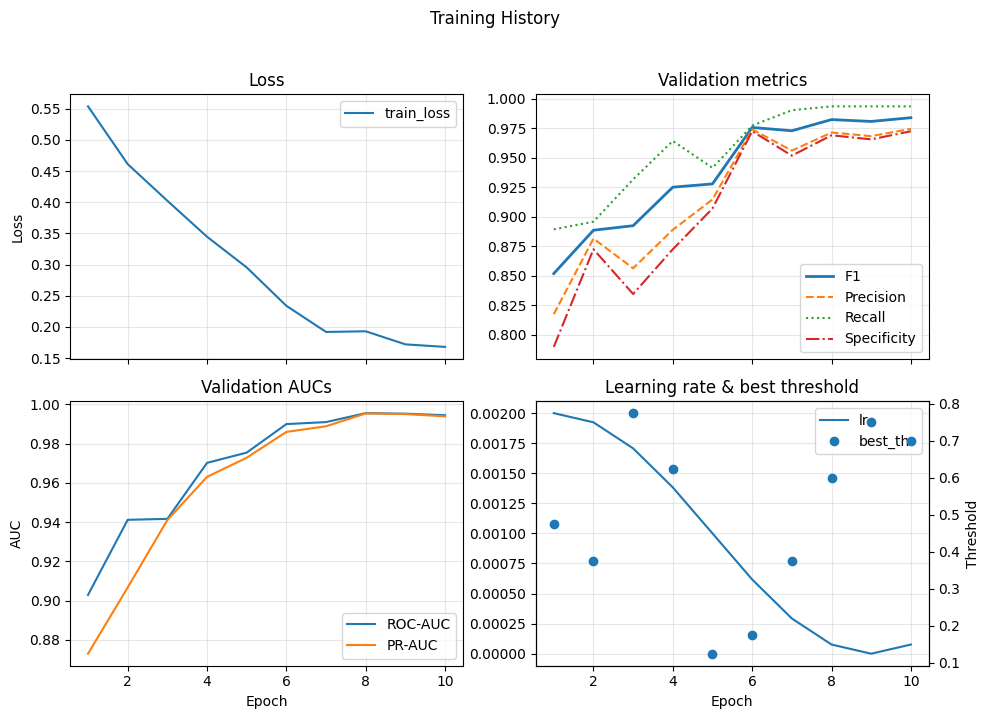

In [49]:
print_training_history(history)

#### 2.2 Evaluate

In [50]:
# Build test dataset/loader exactly as VAL, but name it clearly
test_tfms = val_tfms_fede  # same preprocessing
test_ds   = ImageFolder(root=DATA_ROOT / "testing", transform=test_tfms)

test_loader = DataLoader(
    test_ds, batch_size=16, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2
)

print("TEST classes:", test_ds.classes, test_ds.class_to_idx)


TEST classes: ['flip', 'notflip'] {'flip': 0, 'notflip': 1}


In [51]:
# Load (trusted file)
ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=False)

# Pull fields (cast to built-in Python types to avoid NumPy scalars)
best_thr = float(ckpt.get("best_thr", 0.5))
best_f1  = float(ckpt.get("best_f1", 0.0))
epoch    = int(ckpt.get("epoch", -1))
state    = ckpt["state_dict"]

# Restore model and evaluate
model.load_state_dict(state, strict=True)
model.to(device).eval()
test_stats = evaluate(model, test_loader, device, name="TEST (fixed thr from VAL)", thr=best_thr)
print("TEST stats:", test_stats)

TEST (fixed thr from VAL) @ thr=0.700 | Acc 0.983 | F1 0.984 | Prec 0.974 | Rec 0.993 | Spec 0.972 | ROC-AUC 0.994 | PR-AUC 0.994
Confusion matrix [[TN FP],[FN TP]]:
 [[282   8]
 [  2 305]]
TEST stats: {'thr': 0.7, 'acc': np.float64(0.983249581239531), 'f1': 0.9838709677419355, 'prec': 0.9744408945686901, 'rec': 0.993485342019544, 'spec': np.float64(0.9724137931000951), 'roc': 0.9944962372234079, 'pr': 0.9939297941772354, 'cm': array([[282,   8],
       [  2, 305]])}


## Conclusion

At the fixed decision threshold **0.70**, **FedeNet-Tiny** achieves outstanding performance on the held-out test set:

- **Accuracy:** 0.983  
- **F1-Score:** 0.984  
- **Precision:** 0.974  
- **Recall:** 0.993  
- **Specificity:** 0.972  
- **ROC-AUC:** 0.994  
- **PR-AUC:** 0.994  

The confusion matrix  
`[[TN FP], [FN TP]] = [[282, 8], [2, 305]]`  
shows extremely few misclassifications on both classes.

Despite its simplicity, **FedeNet-Tiny** matches the quality of much larger transfer-learned models while being *orders of magnitude* smaller:

| Model | Parameters | GFLOPs @ 540×960 | Comparison |
|:------|------------:|-----------------:|:------------|
| **FedeNet-Tiny** | **~23K** | **≈ 2.13** | Baseline |
| **MobileNetV2** | 3.5M | 3.1 | ~150× larger |
| **ResNet-18** | 11.7M | 18.7 | ~500× larger |
| **EfficientNet-B0** | 5.3M | 4.03 | ~230× larger |

This remarkable efficiency results from its **dual-stream design**:  
a **spatial branch** focusing on structure and semantics, and a lightweight **frequency branch** fed by fixed Sobel, Laplacian, high-pass, and variance maps, fused late via a small MLP.  

In practice, **FedeNet-Tiny** achieves *near state-of-the-art metrics* with minimal memory usage, low compute cost, and strong generalization—making it an excellent choice for **real-time** or **resource-constrained** applications.


In [52]:
# Re-save a CLEAN checkpoint for future loads (works with PyTorch 2.6 defaults)
CKPT_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_CKPT_PATH = CKPT_DIR / "fedenet_tiny_best_clean.pth"
torch.save({"state_dict": state,
            "best_thr": float(best_thr),
            "epoch": int(epoch),
            "best_f1": float(best_f1)},
           CLEAN_CKPT_PATH)
print("Wrote clean checkpoint to:", CLEAN_CKPT_PATH)

Wrote clean checkpoint to: checkpoints\fedenet_tiny_best_clean.pth


----